# Parameter estimation - Eddington experiment

**References:**
- [ICIC Data Analysis/Statistics workshop 2018](https://www.imperial.ac.uk/astrophysics/centre-for-inference-and-cosmology/seminars-and-events/data-analysis-workshops/)
- [Problem sheet of ICIC Statistics Workshop](https://www.imperial.ac.uk/media/imperial-college/research-centres-and-groups/astrophysics/public/icic/data-analysis-workshop/2018/Eclipse1919-MCMC-project-2018.pdf)
- [Dyson, Eddington and Davidson 1920 paper (Phil. Trans. R. Society, 220, 571)](http://rsta.royalsocietypublishing.org/content/roypta/220/571-581/291.full.pdf)


The aim of this exercise is to analyse photographic plates from Eddington’s 1919 eclipse expedition, to determine whether the data favour Newtonian gravity or Einstein’s General Theory of Relativity. Light from stars that passes close to the Sun is deflected, and during an eclipse, these stars can be detected and their displacements measured, when compared with photographs taken when the Sun is far away.

General Relativity predicts that light passing a mass M at distance r will be bent through an angle

\begin{equation}
    \theta_{\text{GR}}(r)
    =
    \frac{4 G M}{r c^{2}}
\end{equation}

whereas an argument based on Newtonian gravity gives half this:

\begin{equation}
    \theta_{\text{N}}(r)
    =
    \frac{2 G M}{r c^{2}}
\end{equation}

We can either treat this as a parameter inference problem, modelling the bending as

\begin{equation}
    \theta(r)
    =
    \frac{\alpha G M}{r c^{2}}
\end{equation}

and inferring $\alpha$, or as a model comparison problem. For this exercise we will
do the former.

### Data model

\begin{equation}
\begin{aligned}
    Dx^{\text{model exp.}}(\theta, x, y, E_{x}) &= a x + b y + c + \alpha E_{x} \\
    Dy^{\text{model exp.}}(\theta, x, y, E_{y}) &= d x + e y + f + \alpha E_{y}
\end{aligned}
\end{equation}

where:
- $x$, $y$: coordinates of the stars
- $E_{x}$, $E_{y}$: coefficients of the gravitational displacement
- $c$, $f$: corrections to zero
- $a$, $e$: differences of scale value (caused e.g. by changes in temperature)
- $b$, $d$: depend on the orientiation of the two plates
- $\alpha$: deflection at unit distance, i.e (50' from the Sun's centre)


**Parameter of Interest (POI):**
- $\alpha$

**Nuisance parameters (NP):**
- $a$, $b$, $c$, $d$, $e$, $f$

**Parameter vector:**

\begin{equation}
    \mathbf{\theta} = (\alpha, a,b,c,d,e,f)
\end{equation}

**Combined likelihood:**

\begin{equation}
    \mathcal{L} (\theta, \text{all data})
    =
    \prod_{i=star} \mathcal{L}_{i} (\theta, Dx^{\text{obs}}, Dy^{\text{obs}})
\end{equation}

where $\mathcal{L}_{i}$ is:

\begin{equation}
\begin{aligned}
    \mathcal{L}_{i}
    =
    &\frac{1}{\sqrt{2 \pi} \sigma_{Dx}}
    \exp{ \left\{  - \frac{1}{2} \frac{(Dx^{\text{obs}}_{i} - Dx^{\text{model exp.}} (\theta,x_{i},y_{i},E_{x,i}) )^{2}}{\sigma^{2}_{Dx}} \right\} }
    \cdot \\
    &\frac{1}{\sqrt{2 \pi} \sigma_{Dy}}
    \exp{  \left\{ -  \frac{1}{2} \frac{(Dy^{\text{obs}}_{i} - Dy^{\text{model exp.}} (\theta,x_{i},y_{i},E_{y,i}))^{2}}{\sigma^{2}_{Dy}} \right\} }
\end{aligned}
\end{equation}

where:
- $\sigma_{Dx} = 0.05$
- $\sigma_{Dy} = 0.05$

In [1]:
import scipy.stats
import scipy.constants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pint
import ipywidgets
%matplotlib inline

In [2]:
ur = pint.UnitRegistry()

## Deflection angle

In [3]:
M_sol = 1.989*1e30 * ur.kg
M_earth = 5.972 * 1e24 * ur.kg
#r = 149.60 * 1e6 * ur.km
r = 695508 * ur.km
c = scipy.constants.c * ur['m/s']
G = scipy.constants.G * ur['m^3 kg^-1 s^-2']

In [4]:
def calc_theta(alpha):
    
    theta = alpha*G*M_sol/(r*c**2)
    return theta

In [5]:
theta_GR = calc_theta(alpha=4.0)
theta_N  = calc_theta(alpha=2.0)

In [6]:
theta_GR.to('arcsec')

<Quantity(1.7521358677051202, 'arcsecond')>

In [7]:
theta_N.to('arcsec')

<Quantity(0.8760679338525601, 'arcsecond')>

Constructing required functions

In [8]:
def calc_Dx(x,y,alpha,a,b,c,Ex):
    Dx = a*x + b*y + c + alpha*Ex
    return Dx

In [9]:
def calc_Dy(x,y,alpha,d,e,f,Ey):
    Dy = d*x + e*y + f + alpha*Ey
    return Dy

def log_likelihood_one_star(par,x,y,Ex,Ey,Dx_obs,Dy_obs,error=0.05):
    
    alpha = par[0]
    a = par[1]
    b = par[2]
    c = par[3]
    d = par[4]
    e = par[5]
    f = par[6]
    Dx_mean = calc_Dx(x,y,alpha,a,b,c,Ex)
    Dy_mean = calc_Dy(x,y,alpha,d,e,f,Ey)
    log_p_Dx = scipy.stats.norm.logpdf(x=Dx_obs, loc=Dx_mean, scale=error)
    log_p_Dy = scipy.stats.norm.logpdf(x=Dy_obs, loc=Dy_mean, scale=error)
    likelihood = log_p_Dx + log_p_Dy
    
    return likelihood

In [66]:
def log_likelihood_one_star(par,x,y,Ex,Ey,Dx_obs,Dy_obs,sigma_Dx=0.05, sigma_Dy=0.05):
    
    alpha = par[0]
    a     = par[1]
    b     = par[2]
    c     = par[3]
    d     = par[4]
    e     = par[5]
    f     = par[6]
    
    Dx_mean = calc_Dx(x,y,alpha,a,b,c,Ex)
    Dy_mean = calc_Dy(x,y,alpha,d,e,f,Ey)
    
    log_p_Dx = ((Dx_obs - Dx_mean)/sigma_Dx)**2
    log_p_Dy = ((Dy_obs - Dy_mean)/sigma_Dy)**2
    
    #log_p_Dx = scipy.stats.norm.logpdf(x=Dx_obs, loc=Dx_mean, scale=error)
    #log_p_Dy = scipy.stats.norm.logpdf(x=Dy_obs, loc=Dy_mean, scale=error)
    
    likelihood = log_p_Dx + log_p_Dy
    
    return likelihood

In [171]:
def log_likelihood_combined(stars, par, error=0.05):
    
    ll_comb = 0.0
    
    for index, star in stars.iterrows():
        
        x = star['x']
        y = star['y']
        Ex = star['Ex']
        Ey = star['Ey']
        Dx_obs = star['Dx_obs']
        Dy_obs = star['Dy_obs']
        
        arg = (par,x,y,Ex,Ey,Dx_obs,Dy_obs)
        ll_star  = log_likelihood_one_star(*arg)
        #print(star)
        #print(*arg)
        #print(ll_star)
        ll_comb += ll_star
        
    return ll_comb

In [172]:
def create_df_with_Dx_Dy_preds(df_original, par, error=0.05):
    
    df = df_original.copy()

    df['Dx_pred'] = 0.0
    df['Dy_pred'] = 0.0
    df['log_likelihood'] = 0.0
        
    for index, star in df.iterrows():
        
        x = star['x']
        y = star['y']
        Ex = star['Ex']
        Ey = star['Ey']
        Dx_obs = star['Dx_obs']
        Dy_obs = star['Dy_obs']

        alpha = par[0]
        a = par[1]
        b = par[2]
        c = par[3]
        d = par[4]
        e = par[5]
        f = par[6]

        Dx_pred_ = calc_Dx(x,y,alpha,a,b,c,Ex)
        Dy_pred_ = calc_Dy(x,y,alpha,d,e,f,Ey)

        df.at[index, 'Dx_pred'] = Dx_pred_
        df.at[index, 'Dy_pred'] = Dy_pred_
        arg = par, x, y, Ex, Ey, Dx_obs, Dy_obs
        log_likelihood = log_likelihood_one_star(*arg)
        #print(star)
        #print(*arg)
        #print(log_likelihood)
        
        df.at[index, 'log_likelihood'] = log_likelihood
        
        #df.iloc[idx]['Dx_pred'] = Dx_pred
        #df.iloc[idx]['Dy_pred'] = Dy_pred
        
    return df

### Loading in data

In [173]:
stars = pd.read_csv('eddington.dat', delim_whitespace=True, header=1, skiprows=0)

Correcting $Dx$ and $Dy$

In [174]:
stars['Dx_obs'] = stars['Dx_obs_uncorrected']+1.5
stars['Dy_obs'] = stars['Dy_obs_uncorrected']+1.324

In [175]:
stars

,x,y,Ex,Ey,Dx_obs_uncorrected,Dy_obs_uncorrected,Dx_obs,Dy_obs
0,-1.261,-0.160,-0.587,0.036,-1.416,-1.324,0.084,0.000
1,-0.160,-1.107,-0.557,-0.789,-1.221,-1.312,0.279,0.012
2,0.334,0.472,-0.186,1.336,-1.054,-0.944,0.446,0.380
3,0.348,0.360,-0.222,1.574,-1.079,-0.862,0.421,0.462
4,0.587,1.099,0.080,0.726,-1.012,-0.932,0.488,0.392
5,0.860,1.321,0.158,0.589,-0.999,-0.948,0.501,0.376
6,1.079,-0.328,1.540,-0.156,-0.733,-1.019,0.767,0.305


### Exploration

#### Position of the stars $(x,y)$

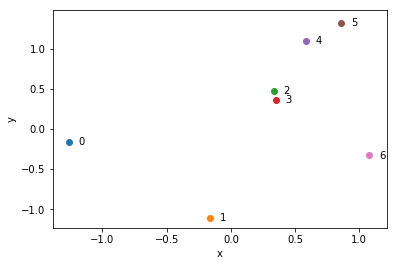

In [176]:
f,a = plt.subplots()

for idx,star in stars.iterrows():
    label = "star {}".format(idx)
    c = "C{}".format(idx)
    x = star['x']
    y = star['y']
    a.scatter(x, y, label=label, c=c)
    txt = "{}".format(idx)
    a.text(x+0.1, y, txt, verticalalignment='center', horizontalalignment='center')
    
a.set_xlabel('x')
a.set_ylabel('y');

#### Deflections $(Dx,Dy)$

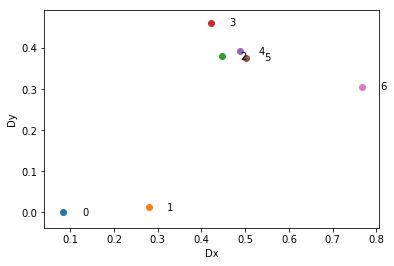

In [177]:
f,a = plt.subplots()

for idx,star in stars.iterrows():
    label = "star {}".format(idx)
    c = "C{}".format(idx)
    Dx_obs = star['Dx_obs']
    Dy_obs = star['Dy_obs']
    a.scatter(Dx_obs, Dy_obs, label=label, c=c)
    
    txt = "{}".format(idx)
    a.text(Dx_obs+0.05, Dy_obs, txt, verticalalignment='center', horizontalalignment='center')
    
a.set_xlabel('Dx')
a.set_ylabel('Dy');

### Testing a specific prediction

In [178]:
par = (1.75/19.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

In [179]:
stars_with_pred = create_df_with_Dx_Dy_preds(stars, par)

In [180]:
stars_with_pred

,x,y,Ex,Ey,Dx_obs_uncorrected,Dy_obs_uncorrected,Dx_obs,Dy_obs,Dx_pred,Dy_pred,log_likelihood
0,-1.261,-0.160,-0.587,0.036,-1.416,-1.324,0.084,0.000,-0.051881,0.003182,7.389542
1,-0.160,-1.107,-0.557,-0.789,-1.221,-1.312,0.279,0.012,-0.049230,-0.069735,45.766154
2,0.334,0.472,-0.186,1.336,-1.054,-0.944,0.446,0.380,-0.016439,0.118081,112.980742
3,0.348,0.360,-0.222,1.574,-1.079,-0.862,0.421,0.462,-0.019621,0.139116,119.360410
4,0.587,1.099,0.080,0.726,-1.012,-0.932,0.488,0.392,0.007071,0.064167,135.507072
5,0.860,1.321,0.158,0.589,-0.999,-0.948,0.501,0.376,0.013965,0.052058,136.856721
6,1.079,-0.328,1.540,-0.156,-0.733,-1.019,0.767,0.305,0.136111,-0.013788,199.858601


Initializiation

In [181]:
par0 = (1.75/19.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

In [182]:
stars

,x,y,Ex,Ey,Dx_obs_uncorrected,Dy_obs_uncorrected,Dx_obs,Dy_obs
0,-1.261,-0.160,-0.587,0.036,-1.416,-1.324,0.084,0.000
1,-0.160,-1.107,-0.557,-0.789,-1.221,-1.312,0.279,0.012
2,0.334,0.472,-0.186,1.336,-1.054,-0.944,0.446,0.380
3,0.348,0.360,-0.222,1.574,-1.079,-0.862,0.421,0.462
4,0.587,1.099,0.080,0.726,-1.012,-0.932,0.488,0.392
5,0.860,1.321,0.158,0.589,-0.999,-0.948,0.501,0.376
6,1.079,-0.328,1.540,-0.156,-0.733,-1.019,0.767,0.305


In [183]:
l0 = log_likelihood_combined(stars, par)

In [184]:
l0

757.7192425670848

In [191]:
np.random.uniform()

0.970133252146429

In [194]:
np.random.normal(scale=1.0)

0.5938947766270118

In [205]:
arr = np.array([('Rex', 9, 81.0), ('Fido', 3, 27.0)], dtype=[('name', 'U10'), ('age', 'i4'), ('weight', 'f4')])

In [207]:
for r in arr:
    print(r['name'])

Rex
Fido
